In [116]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("asm_full_opt")
from phase_mask import PhaseMask
from asm_prop import ASMPropagator
from pixel_map import PixelMap
from psf_conv import PSFConv
from im_postprocess import PostProcess
import config
from IPython.display import FileLink

import os
file_path = os.path.abspath("store_outputs/MNIST_9x9/MNIST_9x9_phase_init.pt")
phase_init = torch.load(file_path, map_location="cpu")

print("Initial phase shape:", phase_init.shape)

Initial phase shape: torch.Size([16, 255, 255])


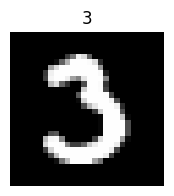

In [117]:
from torchvision.datasets import MNIST

ds = MNIST(root="./data", train=False, download=False)

batch_size = 64

for bi, i0 in enumerate(range(0, len(ds), batch_size)):
    objs = []
    labels = []

    i1 = min(i0 + batch_size, len(ds))
    for i in range(i0, i1):
        x_pil, y = ds[i]  # <-- single index access only
        objs.append(torch.from_numpy(np.array(x_pil)).float() / 255.0)
        labels.append(y)

    objs = torch.stack(objs, dim=0)       # [B, 28, 28]
    labels = torch.tensor(labels)         # [B]

plt.figure(figsize=(2, 2))
plt.imshow(objs[12], cmap="gray", vmin=0, vmax=1)
plt.title(labels[12].item())
plt.axis("off")
plt.show()


In [118]:
from full_opt_forward import FullOptForward

asm = ASMPropagator(config)
phase = PhaseMask(
    config,
    init="custom",
    custom=phase_init,
    X=asm.X,
    Y=asm.Y,    
)
pm = PixelMap(config, asm.X, asm.Y)
conv = PSFConv(config, pm, asm.X, asm.Y)

pp = PostProcess(config, pixel_map=pm, X=asm.X, Y=asm.Y)
model = FullOptForward(config, phase, asm, conv, pp)



In [127]:
# ---- Batched optical forward over MNIST test set ----

batch_size = 500

all_imgs = []
all_labels = []

model.eval()
with torch.no_grad():
    for bi, i0 in enumerate(range(0, len(ds), batch_size)):
        i1 = min(i0 + batch_size, len(ds))

        # Build batch objs from dataset
        objs = []
        labels = []
        for i in range(i0, i1):
            x_pil, y = ds[i]
            objs.append(torch.from_numpy(np.array(x_pil)).float() / 255.0)
            labels.append(y)

        objs = torch.stack(objs, dim=0)   # [B,28,28]
        objs = torch.rot90(objs, k=0, dims=(-2, -1))
        labels = torch.tensor(labels)

        # ---- YOUR PIPELINE ----
        imgs = model.optical_forward(objs)
        imgs = pp(imgs, subtract=False)

        all_imgs.append(imgs.cpu())
        all_labels.append(labels)

# Concatenate full test set
all_imgs = torch.cat(all_imgs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

print("Final:")
print("all_imgs:", all_imgs.shape)
print("all_labels:", all_labels.shape)


Final:
all_imgs: torch.Size([10000, 16, 28, 28])
all_labels: torch.Size([10000])


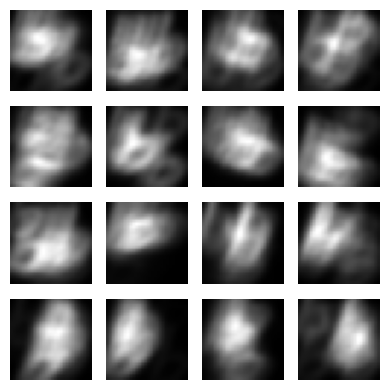

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize=(4, 4))
for k in range(16):
    ax[k//4, k%4].imshow(all_imgs[12, k].T, cmap="gray",origin='lower')
    ax[k//4, k%4].axis("off")
plt.tight_layout()


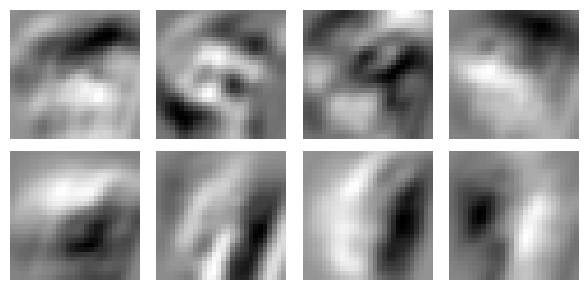

In [129]:
pos = all_imgs[:, 0::2]   # channels 0,2,4,...,14  -> [N, 8, 28, 28]
neg = all_imgs[:, 1::2]   # channels 1,3,5,...,15  -> [N, 8, 28, 28]

feat_maps = pos - neg     # [N, 8, 28, 28]
feat_maps = torch.rot90(feat_maps, k=3, dims=(-2, -1))


fig, ax = plt.subplots(2, 4, figsize=(6, 3))
for k in range(8):
    ax[k//4, k%4].imshow(feat_maps[12, k], cmap="gray")
    ax[k//4, k%4].axis("off")
plt.tight_layout()


In [130]:
import torch
import torch.nn.functional as F

# ---- load FC weights ----
state = torch.load("store_outputs/MNIST_9x9/MNIST_9x9_fc_final.pt")
W = state["weight"]   # [10, 1152]
b = state["bias"]     # [10]

# ---- 2x2 max pool ----
x = F.max_pool2d(feat_maps, 2)  # [N,8,12,12]

# ---- flatten ----
x = x.view(x.size(0), -1)  

# ---- linear classifier ----
logits = x @ W.t() + b     # [N,10]

# ---- accuracy ----
preds = logits.argmax(dim=1)
acc = (preds == all_labels).float().mean()

print(f"Classification accuracy: {acc.item()*100:.2f}%")


Classification accuracy: 25.51%
